<a href="https://colab.research.google.com/github/darisoy/EE517_Sp21/blob/master/hw3/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install sentencepiece
!pip install transformers

     |████████████████████████████████| 2.1MB 18.9MB/s 
     |████████████████████████████████| 3.3MB 53.7MB/s 
     |████████████████████████████████| 901kB 53.6MB/s 


In [3]:
import numpy as np
import pandas as pd
import math
import torch
from tqdm.notebook import tqdm
import pickle
from torch.utils.data import TensorDataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load and check the data

In [ ]:
# not being used on this notebook
labels = {'O' : 0,
          'B-geo-loc' : 1,
          'I-geo-loc' : 2,
          'B-product' : 3,
          'I-product' : 4,
          'B-facility' : 5,
          'I-facility' : 6,
          'B-company' : 7,
          'I-company' : 8,
          'B-person' : 9,
          'I-person' : 10,
          'B-sportsteam' : 11,
          'I-sportsteam' : 12,
          'B-musicartist' : 13,
          'I-musicartist' : 14,
          'B-movie' : 15,
          'I-movie' : 16,
          'B-facility' : 17,
          'I-facility' : 18,
          'B-other' : 19,
          'I-other' : 20,
          }

In [65]:
def one_hot(df):
    column = np.array(df.tag).reshape(-1, 1)
    enc = OneHotEncoder()
    enc.fit(column)
    # tags_matrix = enc.transform(column).toarray()
    df["tag"] = enc.transform(column).toarray().tolist()
    return df

def get_sentences(df):
    sentences = []
    labels = []

    running_sentence = ['<BEG>']
    runnnig_label = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]
    for idx, row in df.iterrows():
        running_sentence.append(row.word)
        runnnig_label.append(row.tag)
        if row.word == '<END>':
            sentences.append(running_sentence)
            labels.append(runnnig_label)

            running_sentence = ['<BEG>']
            runnnig_label = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]

    return sentences, labels

def get_data(type):
    data = pd.read_csv('https://raw.githubusercontent.com/aritter/twitter_nlp/master/data/annotated/wnut16/data/' + type, delimiter='\t', names=["word", "tag"], skip_blank_lines=False, quoting=3)
    data = data.fillna({'word': '<END>', 'tag': 'O'})
    data = one_hot(data)
    return get_sentences(data)

In [66]:
train_sentences, train_tags = get_data('train')
valid_sentences, valid_tags = get_data('dev')
test_sentences, test_tags = get_data('test')

In [68]:
print("Training data: ", len(train_sentences))
print("Dev data: ", len(valid_sentences))
print("Test data: ", len(test_sentences))

Training data:  2394
Dev data:  1005
Test data:  3878


### Load the model

In [69]:
model_name = "distilbert-base-uncased"
model = DistilBertModel.from_pretrained(model_name)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

### Preprocessing before sending to the model

In [70]:
def get_max_len(tokenized):
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    return max_len

In [72]:
# This turns every word into the list of ids
tokenized_train = train_sentences.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized_valid = valid_sentences.word.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized_test = test_sentences.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

AttributeError: ignored

In [29]:
tokenized_train[0]

[101, 1030, 3520, 9856, 27610, 25855, 2213, 102]

In [26]:
# Padding
max_len = max(get_max_len(tokenized_train), get_max_len(tokenized_valid), get_max_len(tokenized_test))
padded_train = np.array([i + [0]*(max_len-len(i)) for i in tokenized_train.values])
padded_valid = np.array([i + [0]*(max_len-len(i)) for i in tokenized_valid.values])
padded_test = np.array([i + [0]*(max_len-len(i)) for i in tokenized_test.values])

print("Padded shape (train): ", np.array(padded_train).shape)
print("Padded shape (valid): ", np.array(padded_valid).shape)
print("Padded shape (test): ", np.array(padded_test).shape)

Padded shape (train):  (39588, 3077)
Padded shape (valid):  (15310, 3077)
Padded shape (test):  (51865, 3077)


In [ ]:
# Tell BERT to ignore padding
attention_mask_train = np.where(padded_train != 0, 1, 0)
attention_mask_valid = np.where(padded_dev != 0, 1, 0)
attention_mask_valid = np.where(padded_dev != 0, 1, 0)

In [ ]:
label_train_orig = df_train['label'].to_numpy()
label_dev_orig = df_dev['label'].to_numpy()

In [ ]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(padded_train), torch.from_numpy(attention_mask_train), torch.from_numpy(label_train_orig))
valid_data = TensorDataset(torch.from_numpy(padded_dev), torch.from_numpy(attention_mask_dev), torch.from_numpy(label_dev_orig))

# dataloaders
batch_size = 64

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)

In [ ]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_mask_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample input mask size: ', sample_mask_x.size()) # batch_size, seq_length
print('Sample input mask: \n', sample_mask_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([64, 66])
Sample input: 
 tensor([[  101,  6361,  2062,  ...,     0,     0,     0],
        [  101,  3005,  2806,  ...,     0,     0,     0],
        [  101,  2022,  2178,  ...,     0,     0,     0],
        ...,
        [  101,  1997, 26452,  ...,     0,     0,     0],
        [  101,  2008,  3248,  ...,     0,     0,     0],
        [  101, 12246,  2058,  ...,     0,     0,     0]])

Sample input mask size:  torch.Size([64, 66])
Sample input mask: 
 tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

Sample label size:  torch.Size([64])
Sample label: 
 tensor([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0])


### Using BERT to encode

In [ ]:
def get_embeddings(target_loader):

    model.eval()
    model.to(device)

    all_embed = []
    all_label = []

    for sample, sample_mask, label in target_loader:
        with torch.no_grad():
            sample, sample_mask = sample.to(device), sample_mask.to(device)
            last_hidden_states = model(sample, attention_mask=sample_mask)
            # get all sentences, all hidden unit outputs, at [CLS] (if output hidden state)
            all_embed.append(last_hidden_states[0][:,0,:])
            all_label.append(label)

    return torch.cat(all_embed,dim =0), torch.cat(all_label)

In [ ]:
train_embed, train_label = get_embeddings(train_loader)
dev_embed, dev_label = get_embeddings(valid_loader)

In [ ]:
train_embed = train_embed.cpu().numpy()
dev_embed = dev_embed.cpu().numpy()
print("train features and labels: ", train_embed.shape, train_label.shape)
print("dev features and labels: ", dev_embed.shape, dev_label.shape)

train features and labels:  (67349, 768) torch.Size([67349])
dev features and labels:  (872, 768) torch.Size([872])


In [ ]:
bert_embeddings = [train_embed, train_label, dev_embed, dev_label]

In [ ]:

# Instead of taking a long time get the embeddings again, we save them
with open('/content/drive/MyDrive/SST-2/ee517_hw2_bert_embeddings.data', 'wb') as data_save:
    # store the data as binary data stream
    pickle.dump(bert_embeddings, data_save)

### Logistic Regression Classifier on top of BERT

In [ ]:
# Now we can just load the embeddings
with open('/content/drive/MyDrive/SST-2/ee517_hw2_bert_embeddings.data', 'rb') as filehandle:
    # read the data as binary data stream
    train_embed, train_label, dev_embed, dev_label = np.array(pickle.load(filehandle), dtype=object)

In [ ]:
# Set random seed for reproducibility
np.random.seed(12345)

# Sample for validation indices
num_validation = round(1/10 * len(train_label))
sample_idx = np.random.choice(len(train_label), size = num_validation , replace=False)
val_embed = train_embed[sample_idx]
val_label = np.array(train_label)[sample_idx]

# Keep the rest for training 
train_idx = np.array(list(filter(lambda x: x not in sample_idx, range(len(train_label)))))
train_embed = train_embed[train_idx]
train_label = np.array(train_label)[train_idx]

We use the logistic regression classifier, and choose the hyperparameter C based on the development set. C is the inverse of regularization strength. It must be a positive float, where smaller values specify stronger regularization. 

In [ ]:
# NOTE: this takes very long to run so we saved the validation errors in a pickle file

values_c = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9,  1.0]
train_acc_c = []
val_acc_c = []
for i in tqdm(range(len(values_c))):
    
    c = values_c[i]
    # Define Logistic Regression model
    np.random.seed(12345)
    lr_model = LogisticRegression(random_state=2, C = c, solver='lbfgs', max_iter = 4000)
    # Fit the model to training data
    lr_model.fit(train_embed, train_label)
    # make prediction using the trained model
    y_train_pred = lr_model.predict(train_embed)
    y_val_pred = lr_model.predict(val_embed)

    train_accuracy = accuracy_score(train_label, y_train_pred)
    val_accuracy = accuracy_score(val_label, y_val_pred)

    print("Training accuracy:", train_accuracy)
    print("Validation accuracy:", val_accuracy) 
    train_acc_c.append(train_accuracy)
    val_acc_c.append(val_accuracy)



with open('ee517_hw2_val_acc_c.data', 'wb') as data_save:
    # store the data as binary data stream
    pickle.dump([train_acc_c, val_acc_c], data_save)

Training accuracy: 0.5606790510443131
Validation accuracy: 0.5567928730512249
Training accuracy: 0.7801003068598014
Validation accuracy: 0.7765404602821084
Training accuracy: 0.8410763190022107
Validation accuracy: 0.8417223459539718
Training accuracy: 0.857013231266704
Validation accuracy: 0.8580549368968077
Training accuracy: 0.8668954366977926
Validation accuracy: 0.8685968819599109
Training accuracy: 0.8700960174217177
Validation accuracy: 0.8711210096510764
Training accuracy: 0.8710033985547894
Validation accuracy: 0.8712694877505568
Training accuracy: 0.8712838618141023
Validation accuracy: 0.8712694877505568
Training accuracy: 0.8713168574916685
Validation accuracy: 0.8708240534521158
Training accuracy: 0.871514831557066
Validation accuracy: 0.8708240534521158



In [ ]:
# Instead of taking a long time to try different setups on the validation set, we load the pickle file we saved
with open('ee517_hw2_val_acc_c.data', 'rb') as filehandle:
    # read the data as binary data stream
    train_acc_c, val_acc_c = np.array(pickle.load(filehandle))

We plot the accuracies obtained on the validation set across different representations and values of C.

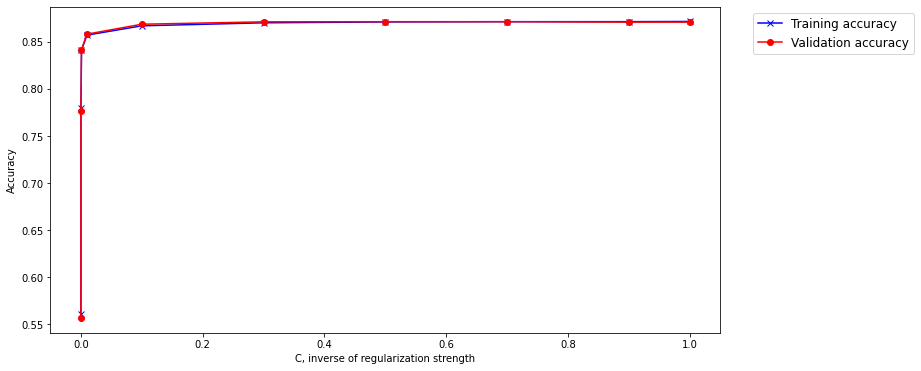

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(values_c, train_acc_c, 'bx-', label = "Training accuracy")
plt.plot(values_c, val_acc_c, 'ro-', label = "Validation accuracy")


#plt.title('Accuracy different setups')
plt.xlabel('C, inverse of regularization strength')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", fontsize=12)
plt.show()

In [ ]:
max_val_idx = np.where(val_acc_c == max(val_acc_c))[0][0]
c_chosen = values_c[max_val_idx]
print("C chosen :", c_chosen, "; Val acc", val_acc_c[max_val_idx])

C chosen : 0.5 ; Val acc 0.8712694877505568


We see that we obtained the highest validation accuracy of 87.13% when we set C = 0.5. Therefore, we will use this as our best model.

In [ ]:
# Define Logistic Regression model
#lr_model = LogisticRegression(random_state=0, solver='liblinear')
lr_model = LogisticRegression(random_state=2, C = c_chosen, solver='lbfgs', max_iter = 4000)
# Fit the model to training data
lr_model.fit(train_embed, train_label)

# make prediction using the trained model
y_train_pred = lr_model.predict(train_embed)
y_val_pred = lr_model.predict(dev_embed)

In [ ]:
train_accuracy = accuracy_score(train_label, y_train_pred)
val_accuracy = accuracy_score(dev_label, y_val_pred)

print("Training accuracy:", train_accuracy)
print("Test accuracy:", val_accuracy) 

Training accuracy: 0.8710033985547894
Test accuracy: 0.8291284403669725
